# IMPORT

In [20]:
from apread import APReader
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import struct
from scipy.optimize import curve_fit

from scipy.signal import welch, csd
from scipy.signal import butter, filtfilt
import capytaine as cpt 



#

#  DRAG NEDYKKET AKTERSPEIL


In [21]:

def bin_to_dataframe(bin_file):
    reader = APReader(bin_file)
    data = {str(ch).split('"')[1]: ch.data for ch in reader.Channels}
    time_key = [key for key in data if "Time" in key][0]
    df = pd.DataFrame(data)
    df.set_index(time_key, inplace=True)
    return df

# Global for caching wetted area from Capytaine, used by wetted_area_from_dynamic_py
_cached_wetted_area_dynamic_py = None

# Hull geometry for transom calculation in calc_Dynamic_Basedrag_coeff_from_dynamic_py
# These are from dynamicBaseDrag.py
WIDTHS_TRANSOM_CBD_DYNAMIC_PY = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
HEIGHTS_TRANSOM_CBD_DYNAMIC_PY = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254]) # m


def wetted_area_from_dynamic_py(mesh_name="2112open.stl", rotation_center=None):
    """
    Calculates wetted surface area using Capytaine. Based on wetted_area from dynamicBaseDrag.py.
    Uses caching.
    """
    global _cached_wetted_area_dynamic_py
    if _cached_wetted_area_dynamic_py is not None:
        return _cached_wetted_area_dynamic_py
   
    mesh = cpt.load_mesh(mesh_name,file_format="stl") # cpt should be imported (capytaine)

    rc = rotation_center or mesh.center_of_buoyancy

    body = cpt.FloatingBody(
        mesh=mesh,
        dofs=cpt.rigid_body_dofs(rotation_center=rc),
        center_of_mass=rc  # use COB if CG unknown
    )
    hydro = body.compute_hydrostatics(rho=1000, g=9.81)
    # print(f"Hydrostatics (dynamicBaseDrag.py method): {hydro}") # Optional: for debugging
    _cached_wetted_area_dynamic_py = float(hydro["wet_surface_area"])
    return _cached_wetted_area_dynamic_py

def calc_Friction_coeff_speedaligned_from_dynamic_py(file_name, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    """
    Calculates friction coefficient based on ITTC 1957 formula. Based on calc_Friction_coeff_speedaligned from dynamicBaseDrag.py.
    Uses extract_variable_from_filename from this notebook.
    """
    boat_speed = extract_variable_from_filename(file_name, "velocity") # Uses notebook's function

    # ITTC 1957 model-ship correlation line
    # Reynolds number Re = V * L / nu. Assuming L=1m (model length), nu=1e-6 m^2/s (kinematic viscosity of water)
    Re = boat_speed * 1.0 / 1e-6 # Assuming L=1m for simplicity
    if Re <= 0: # Avoid log10 of zero or negative, or division by zero if Re is such that log10(Re)-2 is zero
        # print(f"Warning: Invalid Reynolds number {Re} for {file_name}. Cannot calculate CF.")
        return np.nan
    
    log_Re_minus_2 = np.log10(Re) - 2
    if log_Re_minus_2 == 0: # Avoid division by zero
        # print(f"Warning: (log10(Re) - 2) is zero for {file_name}. Cannot calculate CF.")
        return np.nan
        
    CF = 0.075 / (log_Re_minus_2)**2
    # print(f"CF (dynamicBaseDrag.py method) for {file_name}: {CF}") # Optional: for debugging
    return CF

def calc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=0.005, cutoff_hz=20, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    """
    Calculates dynamic base drag coefficient time series. Based on calc_Dynamic_Basedrag_coeff from dynamicBaseDrag.py.
    Uses helper functions from this notebook (get_speedaligned_channel, bin_to_dataframe).
    Uses wetted_area_from_dynamic_py.
    Uses a hardcoded CF = 0.002.
    """
    water1_unfiltered = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder) # Uses notebook's function
    water2_unfiltered = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder) # Uses notebook's function
    
    if water1_unfiltered is None or water2_unfiltered is None:
        # print(f"Warning: Could not get water probe data for {file_name} in calc_Dynamic_Basedrag_coeff_from_dynamic_py.")
        return np.array([]) # Return empty array if data is missing
    if len(water1_unfiltered) == 0 or len(water2_unfiltered) == 0:
        # print(f"Warning: Empty water probe data for {file_name} in calc_Dynamic_Basedrag_coeff_from_dynamic_py.")
        return np.array([])

    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a_filt = butter(N=3, Wn=norm_cutoff, btype="low") # scipy.signal.butter, filtfilt
    water1 = filtfilt(b, a_filt, water1_unfiltered)
    water2 = filtfilt(b, a_filt, water2_unfiltered)
    
    water_height = (water1 + water2) / 2 + 0.01 # Sensor offset

    # Hull shape (static) - using constants defined above this function
    # WIDTHS_TRANSOM_CBD_DYNAMIC_PY and HEIGHTS_TRANSOM_CBD_DYNAMIC_PY

    wetted_area_transom = []
    for h_val in water_height:
        h_clipped = np.clip(h_val, 0, HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[-1])
        wetted_widths_local = []
        wetted_heights_local = []
        for i in range(len(HEIGHTS_TRANSOM_CBD_DYNAMIC_PY) - 1):
            if HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i+1] >= h_clipped:
                w_interp = WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i] + \
                           (WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i+1] - WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i]) * \
                           (h_clipped - HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i]) / \
                           (HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i+1] - HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i])
                wetted_widths_local += [WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i], w_interp]
                wetted_heights_local += [HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i], h_clipped]
                break
            wetted_widths_local += [WIDTHS_TRANSOM_CBD_DYNAMIC_PY[i]]
            wetted_heights_local += [HEIGHTS_TRANSOM_CBD_DYNAMIC_PY[i]]
        wetted_widths_local = [0] + wetted_widths_local
        wetted_heights_local = [0] + wetted_heights_local
        area = 2 * np.trapezoid(wetted_widths_local, wetted_heights_local)
        wetted_area_transom.append(area)
    wetted_area_transom = np.array(wetted_area_transom)
    
    try:
        wett_area_total = wetted_area_from_dynamic_py("2112open.stl")
    except FileNotFoundError:
        wett_area_total = 0.3# Calls copied Capytaine based wetted area
    wetted_area_minus_transom = wett_area_total - wetted_area_transom

    #CF = 0.002 # Hardcoded as in dynamicBaseDrag.py's version
    CF = calc_Friction_coeff_speedaligned_from_dynamic_py(file_name, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater")
    
    
    # Avoid division by zero or issues with CF being NaN or zero, or negative/zero wetted_area_minus_transom
    if np.isnan(CF) or CF == 0:
        C_BD = np.full_like(wetted_area_transom, np.nan)
    else:
        # Ensure wetted_area_minus_transom is not zero where it matters
        safe_wetted_area_minus_transom = np.where(wetted_area_minus_transom <= 0, 1e-9, wetted_area_minus_transom) # Avoid zero or negative
        
        term_under_sqrt_numerator = (wetted_area_transom / safe_wetted_area_minus_transom)**3
        # Handle potential negative values under sqrt if CF is unexpectedly negative or due to precision
        # or if wetted_area_transom is negative (though clipped earlier)
        term_under_sqrt = np.maximum(term_under_sqrt_numerator / CF, 0) # Ensure non-negative
        
        C_BD = 0.029 * np.sqrt(term_under_sqrt)
    
    # mean_C_BD_full_series = np.mean(C_BD) # For debugging, as in original script
    # print(f"Mean C_BD (full series, dynamicBaseDrag.py method) for {file_name}: {mean_C_BD_full_series}") # Optional

    mid_idx = len(C_BD) // 2
    second_half = C_BD[mid_idx:]
    return second_half

def calculate_mean_CBD_from_dynamic_py(file_name, dt=0.005, cutoff_hz=20, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    """
    Calculates the mean Base Drag Coefficient (CBD) for a given file,
    using the logic from dynamicBaseDrag.py.
    """
    cbd_series_second_half = calc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder
    )
    if cbd_series_second_half is not None and len(cbd_series_second_half) > 0:
        return np.mean(cbd_series_second_half)
    else:
        # print(f"Warning: Could not calculate CBD series (dynamic_py) for {file_name} or series was empty.")
        return np.nan

import numpy as np

def calculate_min_max_CBD_from_dynamic_py(
    file_name, dt=0.005, cutoff_hz=20,
    root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"
):
    """
    Calculates the minimum and maximum Base Drag Coefficient (CBD) for a given file,
    using the logic from dynamicBaseDrag.py.
    Returns (min_cbd, max_cbd) or (np.nan, np.nan) if series is empty or unavailable.
    """
    cbd_series_second_half = calc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder
    )
    if cbd_series_second_half is not None and len(cbd_series_second_half) > 0:
        return np.min(cbd_series_second_half), np.max(cbd_series_second_half)
    else:
        return np.nan, np.nan


def search_file(search_str, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    root = Path(root_folder)
    return [f for f in root.rglob("*.bin") if search_str in f.name]

def extract_variable_from_filename(file_name, variable):
    parts = file_name.split('-', 3)
    if len(parts) < 4:
        raise ValueError("Invalid file name format.")
    date = parts[0]
    velocity = parts[1].replace("_", ".")
    period = parts[2].replace("_", ".")
    steepness_raw, _, test_part = parts[3].partition('#')
    test = test_part.replace(".bin", "")
    if '(' in steepness_raw and ')' in steepness_raw:
        i = steepness_raw.find('(')
        j = steepness_raw.find(')', i)
        steepness_val = steepness_raw[:i]
        info_val = steepness_raw[i+1:j]
    elif '-' in steepness_raw:
        steepness_val, info_val = steepness_raw.split('-', 1)
    else:
        steepness_val = steepness_raw
        info_val = None
    var = variable.lower()
    if var == "date":
        return date
    elif var == "velocity":
        try:
            return float(velocity)
        except ValueError:
            return velocity
    elif var == "period":
        try:
            return float(period)
        except ValueError:
            return period
    elif var == "steepness":
        try:
            return float(steepness_val)
        except ValueError:
            return steepness_val
    elif var == "info":
        return info_val
    elif var in ("test", "testnumber"):
        try:
            return int(test)
        except ValueError:
            return test
    else:
        raise ValueError("Invalid variable requested.")

def get_encounter_frequency(file_name, output_format="hz", root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    import numpy as np

    matches = search_file(file_name, root_folder)
    if not matches:
        raise FileNotFoundError(f"File not found: {file_name}")
    fname = matches[0].name

    # Extract variables from filename
    speed = extract_variable_from_filename(fname, "velocity")       # model speed [m/s]
    wave_period = extract_variable_from_filename(fname, "period")   # wave period [s]

    g = 9.81
    omega = 2 * np.pi / wave_period                 # wave angular frequency
    k = omega**2 / g                                # wave number (deep water)
    omega_e = omega - k * speed                     # encounter angular frequency

    fmt = output_format.lower()
    if fmt in ["hz", "hertz", "frequency"]:
        return omega_e / (2 * np.pi)                # Hz
    elif fmt in ["angular", "angular frequency"]:
        return omega_e                              # rad/s
    elif fmt in ["period", "encounter period"]:
        return 2 * np.pi / omega_e if omega_e != 0 else float("inf")
    else:
        raise ValueError("Invalid format for output.")

def get_channel_data(file_name, channel="Speed", root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    # Use the search_file function to find the file
    matches = search_file(file_name, root_folder)
    if not matches:
        raise FileNotFoundError(f"File not found: {file_name}")
    full_path = matches[0]
  
    df = bin_to_dataframe(str(full_path))
    
    if channel not in df.columns:
        raise ValueError(f"Channel '{channel}' not found in the file.")
    return df[channel]

def plot_test(file_name, channel="Speed", root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    
    matches = list(Path(root_folder).rglob(file_name))
    if not matches:
        print(f"File not found: {file_name}")
        return
    full_path = matches[0]  
    df = bin_to_dataframe(str(full_path))
    
    plt.figure()
    plt.plot(df.index, df[channel], label=file_name)
    plt.xlabel("Time")
    plt.ylabel(channel)
    plt.title(f"Plot of {channel} from {file_name}")
    plt.legend()
    plt.show()

def plot_tests(file_list, channel="Speed", root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    plt.figure()
    for file_name in file_list:
        
        matches = list(Path(root_folder).rglob(file_name))
        if not matches:
            print(f"File not found: {file_name}")
            continue
        full_path = matches[0] 
        df = bin_to_dataframe(str(full_path))
        plt.plot(df.index, df[channel], label=file_name)
    plt.xlabel("Time")
    plt.ylabel(channel)
    plt.title(f"Overlay Plot of {channel} from Multiple Tests")
    plt.legend()
    plt.show()

def get_speedaligned_channel(file_list, plot_channel="FX_total", align_channel="Speed", root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    # hvis en fil putter i liste.
    if isinstance(file_list, str):
        file_list = [file_list]
    for file_name in file_list:
        matches = list(Path(root_folder).rglob(file_name))
        if not matches:
            print(f"File not found: {file_name}")
            continue
        full_path = matches[0]
        try:
            parts = file_name.split("-")
            velocity_str = parts[1]  # eks "0_6"
            target_speed = -float(velocity_str.replace("_", "."))
        except Exception as e:
            print(f"Error extracting target speed from {file_name}: {e}")
            continue
        df = bin_to_dataframe(str(full_path))
        condition = df[align_channel].abs() >= abs(target_speed)
        if not condition.any():
            print(f"Target speed {target_speed} not reached in {file_name}")
            continue
        start_time = condition.idxmax()

        end_time = condition[::-1].idxmax()
        df_aligned = df.loc[start_time:end_time].copy()
        df_aligned.index -= start_time
        return df_aligned[plot_channel]
    return None
def get_speedaligned_channel_secondhalf(file_list, plot_channel="FX_total", align_channel="Speed", root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    # If a single filename is passed, wrap it in a list.
    if isinstance(file_list, str):
        file_list = [file_list]
    for file_name in file_list:
        matches = list(Path(root_folder).rglob(file_name))
        if not matches:
            print(f"File not found: {file_name}")
            continue
        full_path = matches[0]
        try:
            parts = file_name.split("-")
            velocity_str = parts[1]  # expected format e.g., "0_6"
            target_speed = -float(velocity_str.replace("_", "."))
        except Exception as e:
            print(f"Error extracting target speed from {file_name}: {e}")
            continue
        df = bin_to_dataframe(str(full_path))
        condition = df[align_channel].abs() >= abs(target_speed)
        if not condition.any():
            print(f"Target speed {target_speed} not reached in {file_name}")
            continue
        start_time = condition.idxmax()
        end_time = condition[::-1].idxmax()
        df_aligned = df.loc[start_time:end_time].copy()
        df_aligned.index -= start_time
        
        # Compute the halfway index and return only the second half of the window.
        half_index = len(df_aligned) // 2
        df_second_half = df_aligned.iloc[half_index:]
        return df_second_half[plot_channel]
    return None

def find_repeats(param_str, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    root = Path(root_folder)
    return [f.name for f in root.rglob("*.bin") if param_str in f.name]

def calculate_wave_amplitude(filename, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    """
    Beregner bølgeamplituden for en gitt fil basert på dypvannsbølge teori.
    
    Ut fra dypvannsbølgeteori har vi:
      - Bølgelengde L = g * T^2 / (2π)
      - Bølgehøyde H = steepness * L
      - Amplitude A = H / 2 = (steepness * g * T^2) / (4π)
    
    Parametre:
      filename (str): Filnavnet på testen, f.eks. "0801-0_6-0_6-40#1.bin"
      root_folder (str): Mappen der filen befinner seg.
      
    Returnerer:
      Amplituden (float) beregnet for filen.
    """
    # Hent ut steilhet og bølgeperiode fra filnavnet
    try:
        s = 1/extract_variable_from_filename(filename, "steepness")
        T = extract_variable_from_filename(filename, "period")
    except Exception as e:
        raise ValueError("Feil ved utvinning av parameter fra filnavnet: " + str(e))
    
    # Sjekk at både steilhet og periode er numeriske
    if not isinstance(s, (int, float)) or not isinstance(T, (int, float)):
        raise ValueError("Steepness og period må være numeriske verdier.")
    
    # Gravitationsakselerasjon [m/s²]
    g = 9.81
    
    # Beregn bølgelengde i dypvann
    L = g * T**2 / (2 * np.pi)
    
    # Beregn bølgehøyde og amplitude (amplitude = H/2)
    H = s * L
    amplitude = H / 2
    
    return amplitude


def mean_filtered_second_half_wetted_area(file_name, 
                                          wave_channels=("Rel_WP1", "Rel_WP2"),
                                          dt=1/200,  # 200 Hz sampling
                                          cutoff_hz=20.0, # Corrected from bandwidth
                                          root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    """
    Calculates the mean of the filtered second half of the speed-aligned wetted area signal.
    
    Args:
        file_name (str): The test filename.
        wave_channels (tuple): The names of the two water height channels.
        dt (float): Time step, default 1/200 seconds (200 Hz).
        cutoff_hz (float): Cutoff frequency for low-pass filter.
        root_folder (str): Folder to search for the file.
    
    Returns:
        float: Mean wetted area over second half of speed-aligned window.
    """
    from scipy.signal import butter, filtfilt

    # Load the two wave channels
    water1_unfiltered = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)
    
    if water1 is None or water2 is None:
        raise ValueError("Wave channel(s) not found or speed alignment failed.")

    # Average water height
    water_height = (water1 + water2) / 2 + 0.01

    # Hull shape (static)
    widths = np.array([0, 0.04642, 0.0599, 0.0667, 0.07633, 0.08425, 0.09175, 0.09859, 0.10401, 0.09898, 0.093752])
    heights  = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])   # m
   

    # Calculate wetted area time series
    wetted_area = []
    for h in water_height:
        h = np.clip(h, 0, heights[-1])  # Clip within hull limits
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i+1] >= h:
                w_interp = widths[i] + (widths[i+1] - widths[i]) * (h - heights[i]) / (heights[i+1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h]
                break
            wetted_widths += [widths[i]]
            wetted_heights += [heights[i]]
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area.append(area)
    wetted_area = np.array(wetted_area)

    # Apply low-pass filter
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    wetted_area_filtered = filtfilt(b, a, wetted_area)

    # Take second half
    mid_idx = len(wetted_area_filtered) // 2
    second_half = wetted_area_filtered[mid_idx:]

    # Return mean
    return np.mean(second_half)

import numpy as np
from scipy.signal import butter, filtfilt

def min_max_filtered_second_half_wetted_area(
    file_name,
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,           # 200 Hz sampling
    cutoff_hz=20.0,     # Cutoff frequency for low-pass filter
    root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"
):
    """
    Calculates the minimum and maximum of the filtered second half of the
    speed-aligned wetted area signal.
    
    Args:
        file_name (str): The test filename.
        wave_channels (tuple): The names of the two water height channels.
        dt (float): Time step, default 1/200 seconds (200 Hz).
        cutoff_hz (float): Cutoff frequency for low-pass filter.
        root_folder (str): Folder to search for the file.
    
    Returns:
        tuple: (min_wetted_area, max_wetted_area) over second half of filtered signal.
    """
    # Load the two wave channels
    water1_unfiltered = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    
    if water1_unfiltered is None or water2_unfiltered is None:
        raise ValueError("Wave channel(s) not found or speed alignment failed.")
    
    # Design low-pass filter
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    
    # Apply filter to water height signals
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)
    
    # Average water height and add small offset
    water_height = (water1 + water2) / 2 + 0.01

    # Static hull shape (width vs. height)

    # Calculate wetted area time series
    wetted_area = []
    for h in water_height:
        h_clipped = np.clip(h, 0, heights[-1])
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i + 1] >= h_clipped:
                w_interp = widths[i] + (widths[i + 1] - widths[i]) * (
                    h_clipped - heights[i]
                ) / (heights[i + 1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h_clipped]
                break
            wetted_widths.append(widths[i])
            wetted_heights.append(heights[i])
        # Close shape at keel
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area.append(area)
    wetted_area = np.array(wetted_area)

    # Apply low-pass filter to wetted area
    wetted_area_filtered = filtfilt(b, a, wetted_area)

    # Take second half
    mid_idx = len(wetted_area_filtered) // 2
    second_half = wetted_area_filtered[mid_idx:]

    # Return min and max of second half
    return np.min(second_half), np.max(second_half)

_cached_wetted_area = None

widths = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254]) 





def plot_CF_and_CBD(file_name, dt=0.005, cutoff_hz=20, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    #CF = calc_Friction_coeff_speedaligned(file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder)
    CF = 0.002
    C_BD = calc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder)
    
    time = np.arange(len(C_BD)) * dt

    CF_const = CF[0] if hasattr(CF, "__len__") else CF
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, CF_const, label='C_F', color='blue')
    plt.plot(time, C_BD, label='C_BD', color='orange')
    plt.xlabel('Time [s]')
    plt.ylabel('Coefficient')
    plt.title('C_F and C_BD over Time')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_totalDrag_and_BaseDrag(file_name, dt=0.05, cutoff_hz=20, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    totalDragUnfiltered = get_speedaligned_channel(file_name, "FX_total", root_folder=root_folder)
    C_BD = calc_Dynamic_Basedrag_coeff_from_dynamic_py(file_name, dt=dt, cutoff_hz=cutoff_hz, root_folder=root_folder)
    
    nyq = 0.5 / dt
    b, a = butter(3, cutoff_hz/nyq, btype="low")
    totalDrag = filtfilt(b, a, totalDragUnfiltered)
    
    mid_idx = len(totalDrag) // 2
    totalDrag_second_half = totalDrag[mid_idx:]
    
    water1_unfiltered = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder)
    water2_unfiltered = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder)
    #
    nyquist = 0.5 / dt
    norm_cutoff = cutoff_hz / nyquist
    b, a = butter(N=3, Wn=norm_cutoff, btype="low")
    water1 = filtfilt(b, a, water1_unfiltered)
    water2 = filtfilt(b, a, water2_unfiltered)

    
    # Average water height
    water_height = (water1 + water2) / 2 +0.01

    # Hull shape (static)
    widths = np.array([0, 0.04642, 0.0599, 0.0667, 0.07633, 0.08425, 0.09175, 0.09859, 0.10401, 0.09898, 0.093752])
    heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])   

    # Calculate wetted area of transom time series
    wetted_area_transom = []
    for h in water_height:
        wetted_widths = []
        wetted_heights = []
        for i in range(len(heights) - 1):
            if heights[i+1] >= h:
                w_interp = widths[i] + (widths[i+1] - widths[i]) * (h - heights[i]) / (heights[i+1] - heights[i])
                wetted_widths += [widths[i], w_interp]
                wetted_heights += [heights[i], h]
                break
            wetted_widths += [widths[i]]
            wetted_heights += [heights[i]]
        wetted_widths = [0] + wetted_widths
        wetted_heights = [0] + wetted_heights
        area = 2 * np.trapezoid(wetted_widths, wetted_heights)
        wetted_area_transom.append(area)
    wetted_area_transom = np.array(wetted_area_transom)
    
    mid_idx = len(wetted_area_transom) // 2
    wetted_second_half = wetted_area_transom[mid_idx:]
    
    
    D_B = C_BD * 0.5 * 1000 * extract_variable_from_filename(file_name, "velocity")**2 * wetted_second_half
    
    time = np.arange(len(C_BD)) * dt

    plt.figure(figsize=(12, 6))
    plt.plot(time, totalDrag_second_half, label='Total Drag', color='blue')
    plt.plot(time, D_B, label='D_B', color='orange')
    plt.xlabel('Time [s]')
    plt.ylabel('Coefficient')
    plt.title('TotalDrag and Base drag over Time')
    plt.legend()
    plt.grid()
    plt.show()
    





def calc_R_hekk(file_name, dt=0.005, cutoff_hz=20, root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater", rho=1000.0, g=9.81):

    w1_raw = get_speedaligned_channel(file_name, "Rel_WP1", root_folder=root_folder)
    w2_raw = get_speedaligned_channel(file_name, "Rel_WP2", root_folder=root_folder)
    nyq = 0.5 / dt
    b, a = butter(3, cutoff_hz/nyq, btype="low")
    w1 = filtfilt(b, a, w1_raw)
    w2 = filtfilt(b, a, w2_raw)
    
    
    T = (w1 + w2) / 2         # transom-dybde over tid

    # --- 2) statisk skrogprofil (hull shape) ---
    widths = np.array([0, 0.04642, 0.0599, 0.0687, 0.07933, 0.08625, 0.09375, 0.09859, 0.10401, 0.09898, 0.093752])  # m
    heights = np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591, 0.07415, 0.0882, 0.10254])

    # --- 3) for hver T[i], regn ∫₀ᵀ z·B(z) dz via trapz ---
    R_hekk = np.zeros_like(T)
    for i, h in enumerate(np.clip(T, 0, heights[-1])):
        if h == 0:
            continue
        j = np.searchsorted(heights, h) - 1
        # bygg z- og B-vektor opp til h
        z = np.concatenate(( [0], heights[1:j+1], [h] ))
        B_tail = widths[j] + (widths[j+1]-widths[j]) * (h-heights[j])/(heights[j+1]-heights[j])
        B = np.concatenate(( [0], widths[1:j+1], [B_tail] ))
        R_hekk[i] = rho * g * np.trapezoid(z * B, z)
    return R_hekk




def plot_CBD_dynamisk(file_name,
             dt=0.005,
             cutoff_hz=20,
             root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):

    # beregn C_BD-tidsserie (andre halvdel)
    C_BD = calc_Dynamic_Basedrag_coeff_from_dynamic_py(
        file_name,
        dt=dt,
        cutoff_hz=cutoff_hz,
        root_folder=root_folder
    )

    # tid for hver C_BD-verdi
    t = np.arange(len(C_BD)) * dt

    # plott
    plt.figure(figsize=(10, 5))
    plt.plot(t, C_BD, label='C_BD', linewidth=1)
    plt.xlabel('Tid [s]')
    plt.ylabel('Dynamic basedragkoeff. $C_{BD}$')
    plt.title('Tidsserie av dynamic base-drag-koeffisient')
    plt.grid(True)
    plt.legend()
    plt.show()


SENSOR_OFFSET = 0.01    # [m], sensorkalibrering mot vannlinje
CF_CONST      = 0.002 

def compute_transom_area_at_height(h_raw, offset=SENSOR_OFFSET):
    """
    Beregn transom-våtområde [m²] for rå vannhøyde h_raw [m] fra sensor.
    """
    h = np.clip(h_raw + offset, 0.0, heights[-1])
    wetted_w = [0.0]
    wetted_z = [0.0]
    for i in range(len(heights)-1):
        if heights[i+1] >= h:
            w0, w1 = widths[i], widths[i+1]
            z0, z1 = heights[i], heights[i+1]
            w_interp = w0 + (w1 - w0)*(h - z0)/(z1 - z0)
            wetted_w += [w0, w_interp]
            wetted_z += [z0, h]
            break
        wetted_w.append(widths[i])
        wetted_z.append(heights[i])
    area = 2.0 * np.trapezoid(wetted_w, wetted_z)
    return max(area, 0.0)

def CBD_at_given_height( h_raw):
    """
    Beregn base-drag koeff C_BD for én rå vannhøyde h_raw.
    """
    #CF = calc_Friction_coeff_speedaligned(file_name)
    CF = 0.002
    A_trans = compute_transom_area_at_height(h_raw)
    A_total = wetted_area_from_dynamic_py("2112open.stl")
    A_hull  = A_total - A_trans
    ratio   = A_trans/A_hull if A_hull>0 else np.nan
    return 0.029 * np.sqrt((ratio**3)/CF)

def plot_CBD_vs_heights(file_name, num_points=100):
    """
    Plott C_BD som funksjon av rå vannhøyder fra 0 til max-sensorverdi.
    """
    h_vals = np.linspace(0.0, heights[-1]-SENSOR_OFFSET, num_points)
    cbd_vals = [CBD_at_given_height(h) for h in h_vals]
    plt.figure(figsize=(8,5))
    plt.plot(h_vals, cbd_vals, '-', label=r'$C_{BD}(h)$')
    plt.xlabel('Rå vannhøyde h [m]')
    plt.ylabel('Base-drag koeff. $C_{BD}$')
    plt.title('C_{BD} som funksjon av vannhøyde')
    plt.grid(True)
    plt.legend()
    plt.show()


def make_dataframe_all_new(root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"):
    try:
        with open("bin_file_list.txt", "r") as f:
            file_list = f.read().splitlines()
    except Exception as e:
        print("Error reading bin_file_list.txt:", e)
        return None

    records = []

    for file_name in file_list:
        record = {'file': file_name}

        try:
            record['date'] = extract_variable_from_filename(file_name, "date")
        except:
            record['date'] = np.nan

        try:
            record['velocity'] = extract_variable_from_filename(file_name, "velocity")
        except:
            record['velocity'] = np.nan

        try:
            record['period'] = extract_variable_from_filename(file_name, "period")
        except:
            record['period'] = np.nan

        try:
            record['steepness'] = extract_variable_from_filename(file_name, "steepness")
        except:
            record['steepness'] = np.nan

        try:
            record['info'] = extract_variable_from_filename(file_name, "info")
        except:
            record['info'] = np.nan

        try:
            record['test'] = extract_variable_from_filename(file_name, "test")
        except:
            record['test'] = np.nan

        try:
            repeats = find_repeats(file_name)
            record['repeats'] = len(repeats) if repeats else 0
        except:
            record['repeats'] = np.nan

        try:
            record['wave_amplitude'] = calculate_wave_amplitude(file_name)
        except:
            record['wave_amplitude'] = np.nan

        try:
            data_second_half = get_speedaligned_channel_secondhalf(file_name)
            record['mean_second_half'] = (
                np.mean(data_second_half)
                if data_second_half is not None and len(data_second_half) > 0
                else np.nan
            )
        except:
            record['mean_second_half'] = np.nan

        try:
            matches = list(Path(root_folder).rglob(file_name))
            if not matches:
                raise FileNotFoundError(f"File not found for duration: {file_name}")
            df_temp = bin_to_dataframe(str(matches[0]))
            target_speed_str = file_name.split("-")[1].replace("_", ".")
            if not target_speed_str:
                raise ValueError(f"Could not extract target speed from filename: {file_name}")
            target_speed = -float(target_speed_str)

            condition = df_temp["Speed"].abs() >= abs(target_speed)
            if not condition.any():
                raise ValueError("Target speed not reached for duration calculation.")
            start_time_val = df_temp.index[condition.argmax()]
            end_time_val = df_temp.index[len(df_temp.index) - 1 - condition[::-1].argmax()]
            record['test_duration'] = end_time_val - start_time_val
        except:
            record['test_duration'] = np.nan

        try:
            record['mean_wetted_area'] = mean_filtered_second_half_wetted_area(
                file_name, root_folder=root_folder, cutoff_hz=0.2
            )
        except:
            record['mean_wetted_area'] = np.nan

        try:
            record['min_wetted_area'], record['max_wetted_area'] = min_max_filtered_second_half_wetted_area(
                file_name, root_folder=root_folder, cutoff_hz=0.2
            )
        except:
            record['min_wetted_area'] = np.nan
            record['max_wetted_area'] = np.nan

        try:
            record['mean_CBD_dynamic_py'] = calculate_mean_CBD_from_dynamic_py(
                file_name, root_folder=root_folder
            )
        except:
            record['mean_CBD_dynamic_py'] = np.nan

        try:
            record['min_CBD_dynamic_py'], record['max_CBD_dynamic_py'] = calculate_min_max_CBD_from_dynamic_py(
                file_name, root_folder=root_folder
            )
        except:
            record['min_CBD_dynamic_py'] = np.nan
            record['max_CBD_dynamic_py'] = np.nan

        records.append(record)

    return pd.DataFrame(records)

#Denne funksjonen tar inn en tidsserie med vannhøyder på akterspeilet og returnerer en graf som viser basedrag tidsserie






In [22]:
print(calculate_mean_CBD_from_dynamic_py("1501-1_0-0_650-50#1.bin"))


Boundary is not closed !!!
Boundary is not closed !!!
Boundary is not closed !!!
0.000363647736875402


In [23]:
new_dataframe = make_dataframe_all_new()

Error extracting target speed from testrun_0701#1.BIN: list index out of range


Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#1.BIN: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range


Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#2.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range


Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#3.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range


Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#4.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range


Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#5.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range


Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#6.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range


Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#7.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range


Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701#8.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range


Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(bolgemalerTest)#9.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range


Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#1.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range


Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#2.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range


Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#3.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range


Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#4.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range


Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#5.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range


Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701(Repeat0.7)#6.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range


Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range


Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#2.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range


Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#3.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range


Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_8#4.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range


Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range
Error extracting target speed from testrun_0701_0_9#1.bin: list index out of range


Error extracting target speed from testvideo_1.BIN: list index out of range


Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range
Error extracting target speed from testvideo_1.BIN: list index out of range


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Target speed -0.6 not reached in 1101-0_6-1_05-40(error)#1.bin


Error extracting target speed from test#1.bin: list index out of range


Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#1.bin: list index out of range


Error extracting target speed from test#1.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range


Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range
Error extracting target speed from test#2.bin: list index out of range


Error extracting target speed from kameratest#1.bin: list index out of range


Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest#1.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range


Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(30)#3.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range


Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#2.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range


Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#4.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range


Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#5.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range


Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from kameratest(60)#6.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range


Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo14.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range


Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo15.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range


Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideo16.bin: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range


Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_1.BIN: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range


Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_10.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range


Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_2.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range


Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_3.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range


Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_4.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range


Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_5.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range


Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_6.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range


Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_7.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range


Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_8.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range


Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideosync_9.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range


Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_12.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range


Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from testvideo_13.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range


Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range
Error extracting target speed from uitfiy.bin: list index out of range


Error extracting target speed from decayOgReferanse.bin: list index out of range


Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from decayOgReferanse.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range


Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range
Error extracting target speed from testtirsdag.bin: list index out of range


Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range


Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range
Error extracting target speed from DecayEtterEndraTrim.bin: list index out of range


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


Target speed -0.4 not reached in 1801-0_4-0_75-4(STOOOORBOLGENoytralMedTRIP)#1.bin


File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 
File not found: 1901-0_9-0_575-20(NoytralMedTRIP)#1.bin 


Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'


Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'
Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'
Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'
Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'
Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'
Error extracting target speed from 1901-decay+endringavkameraogSjakkbrett#1.bin: could not convert string to float: 'decay+endringavkameraogSjakkbrett#1.bin'
Error extracting target speed from 1901-decay+endrin

Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range
Error extracting target speed from sjakkbrettKalibrering#1.bin: list index out of range


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.5 not reached in 1701-0_5-40(WaveDoc)#1.BIN


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.525 not reached in 1701-0_525-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.55 not reached in 1701-0_550-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.575 not reached in 1701-0_575-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.6 not reached in 1701-0_6-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.625 not reached in 1701-0_625-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-20(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-30(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-40(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.65 not reached in 1701-0_65-50(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.675 not reached in 1701-0_675-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.7 not reached in 1701-0_7-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.725 not reached in 1701-0_725-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.75 not reached in 1701-0_75-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.775 not reached in 1701-0_775-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-30(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-35(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-40(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-45(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.8 not reached in 1701-0_8-50(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.825 not reached in 1701-0_825-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.85 not reached in 1701-0_85-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.875 not reached in 1701-0_875-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin


Target speed -0.9 not reached in 1701-0_9-40(WaveDoc)#1.bin

Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.925 not reached in 1701-0_925-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.95 not reached in 1701-0_95-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -0.975 not reached in 1701-0_975-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin

Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.0 not reached in 1701-1_0-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.025 not reached in 1701-1_025-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.05 not reached in 1701-1_05-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.075 not reached in 1701-1_075-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.1 not reached in 1701-1_1-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.125 not reached in 1701-1_125-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin

Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin


Target speed -1.15 not reached in 1701-1_15-40(WaveDoc)#1.bin
Error extracting target speed from test.BIN: list index out of range


Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from test.BIN: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range


Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp3_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range


Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp4_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range


Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp5_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range


Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp6_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range


Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp7_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range


Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range
Error extracting target speed from wp8_cal.bin: list index out of range


In [ ]:
#new_dataframe.to_csv("my_data.csv", index=False)
df2 = pd.read_csv("my_data.csv")

In [25]:
def plot_cbd_vs_variable(df, x_variable_name, fixed_filters=None,
                         info_filter=None, annotate_points=False,
                         y_limit=None, x_limit=None, return_plotted_data=False):
    """
    Plots Mean CBD (dynamic_py) against a specified variable, allowing other parameters to be held constant.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the data (e.g., new_dataframe).
    x_variable_name : str
        The name of the column to plot on the x-axis (e.g., 'velocity', 'period', 'steepness').
    fixed_filters : dict, optional
        A dictionary to filter the DataFrame. Keys are column names and values are
        the values to filter by (e.g., {'velocity': 0.6, 'steepness': 40}).
    info_filter : str, optional
        A substring to filter the 'info' column by.
    annotate_points : bool, optional
        If True, annotates data points with their 'file' name. Default is False.
    y_limit : tuple, optional
        Tuple (min, max) for the y-axis (CBD) limits.
    x_limit : tuple, optional
        Tuple (min, max) for the x-axis limits.
    return_plotted_data : bool, optional
        If True, returns the DataFrame used for plotting. Default is False.

    Returns:
    --------
    pd.DataFrame or None
        If return_plotted_data is True, returns the filtered DataFrame used for the plot.
        Otherwise, returns None.
    """
    if df is None or df.empty:
        print("Input DataFrame is empty or None.")
        return None

    plot_df = df.copy()

    # Apply fixed filters
    if fixed_filters:
        for col, value in fixed_filters.items():
            if col in plot_df.columns:
                plot_df = plot_df[plot_df[col] == value]
            else:
                print(f"Warning: Filter column '{col}' not found in DataFrame.")

    # Apply info filter
    if info_filter:
        if 'info' in plot_df.columns:
            plot_df = plot_df[plot_df['info'].astype(str).str.contains(info_filter, na=False)]
        else:
            print("Warning: 'info' column not found for info_filter.")

    # Ensure x_variable and CBD columns exist and drop NaNs for plotting
    if x_variable_name not in plot_df.columns:
        print(f"Error: x_variable_name '{x_variable_name}' not found in DataFrame.")
        return None
    if 'mean_CBD_dynamic_py' not in plot_df.columns:
        print("Error: 'mean_CBD_dynamic_py' column not found in DataFrame.")
        return None

    plot_df = plot_df.dropna(subset=[x_variable_name, 'mean_CBD_dynamic_py'])

    if plot_df.empty:
        print(f"No data available for plotting after applying filters for x-variable '{x_variable_name}'.")
        return None

    plot_df = plot_df.sort_values(by=x_variable_name)

    plt.figure(figsize=(10, 6))
    plt.scatter(plot_df[x_variable_name], plot_df['mean_CBD_dynamic_py'], alpha=0.7, label=f'CBD Data Points')

    if annotate_points:
        if 'file' in plot_df.columns:
            for i, point in plot_df.iterrows():
                plt.annotate(point['file'], (point[x_variable_name], point['mean_CBD_dynamic_py']),
                             fontsize=7, xytext=(5, -5), textcoords='offset points', alpha=0.6)
        else:
            print("Warning: 'file' column not found for annotation.")

    plt.xlabel(x_variable_name.replace('_', ' ').capitalize() + (f" [{plot_df[x_variable_name].dtype}]" if pd.api.types.is_numeric_dtype(plot_df[x_variable_name]) else ""))
    plt.ylabel('Mean CBD (dynamic_py)')

    title_parts = [f'Mean CBD vs. {x_variable_name.replace("_", " ").capitalize()}']
    if fixed_filters:
        filter_str = ", ".join([f"{k}={v}" for k, v in fixed_filters.items()])
        title_parts.append(f" (Fixed: {filter_str})")
    if info_filter:
        title_parts.append(f" (Info contains: '{info_filter}')")
    plt.title("".join(title_parts))

    if y_limit:
        plt.ylim(y_limit)
    if x_limit:
        plt.xlim(x_limit)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if return_plotted_data:
        return plot_df
    return None

plot_cbd_vs_variable(
    df=new_dataframe,
    x_variable_name='velocity',
    fixed_filters={'steepness': 40},
    info_filter="Missing value",  # Replace "SomeInfoString" with the actual info you want to filter by
    annotate_points=True
)

No data available for plotting after applying filters for x-variable 'velocity'.


Rows after base filter: 193
Unique velocities found: [0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]
  Velocity = 0.6, rows: 23
  Velocity = 0.7, rows: 30
  Velocity = 0.8, rows: 23
  Velocity = 0.9, rows: 32


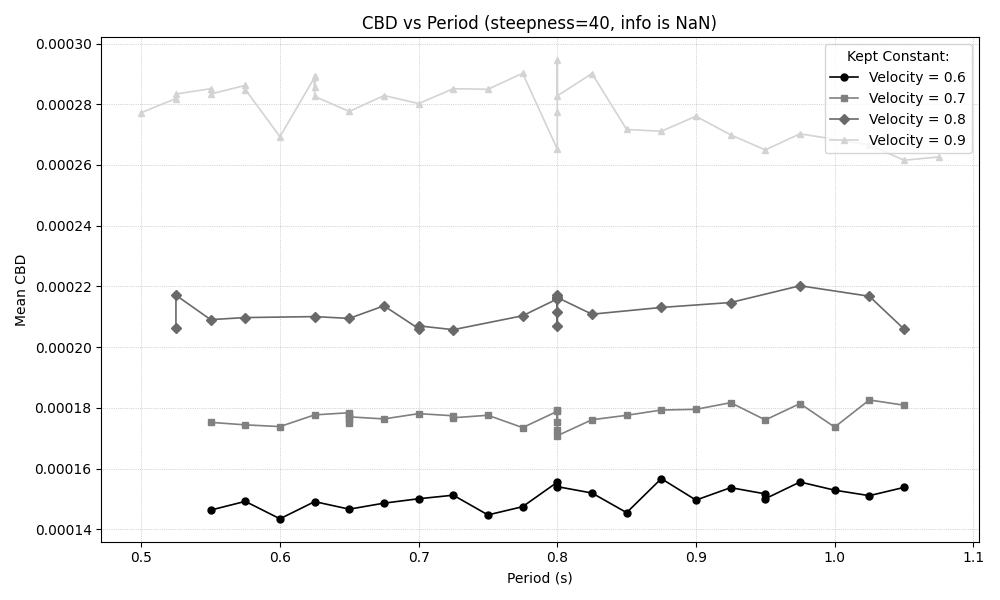

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Base-filter: steepness = 40 and info is NaN
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))
print("Unique velocities found:", np.sort(df_base["velocity"].unique()))

# 2) Pick up to 4 distinct velocities
unique_vels = np.sort(df_base["velocity"].unique())
vels_to_plot = unique_vels[:4]

# 3) Plot CBD vs Period at four fixed velocities
plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray", "lightgray"]
markers = ["o", "s", "D", "^"]

for idx, V in enumerate(vels_to_plot):
    df_V = df_base[df_base["velocity"] == V].dropna(subset=["period", "mean_CBD_dynamic_py"])
    print(f"  Velocity = {V}, rows: {len(df_V)}")
    if df_V.empty:
        continue

    df_V = df_V.sort_values(by="period")
    plt.plot(
        df_V["period"],
        df_V["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Velocity = {V}"
    )

plt.xlabel("Period (s)")
plt.ylabel("Mean CBD")
plt.title("CBD vs Period (steepness=40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Rows after base filter: 193
All unique periods: [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075
 1.1  ]
Selected periods (evenly spaced): [0.5, 0.7, 0.9, 1.1]
  Period = 0.5, rows: 2
  Period = 0.7, rows: 9
  Period = 0.9, rows: 7
  Period = 1.1, rows: 1


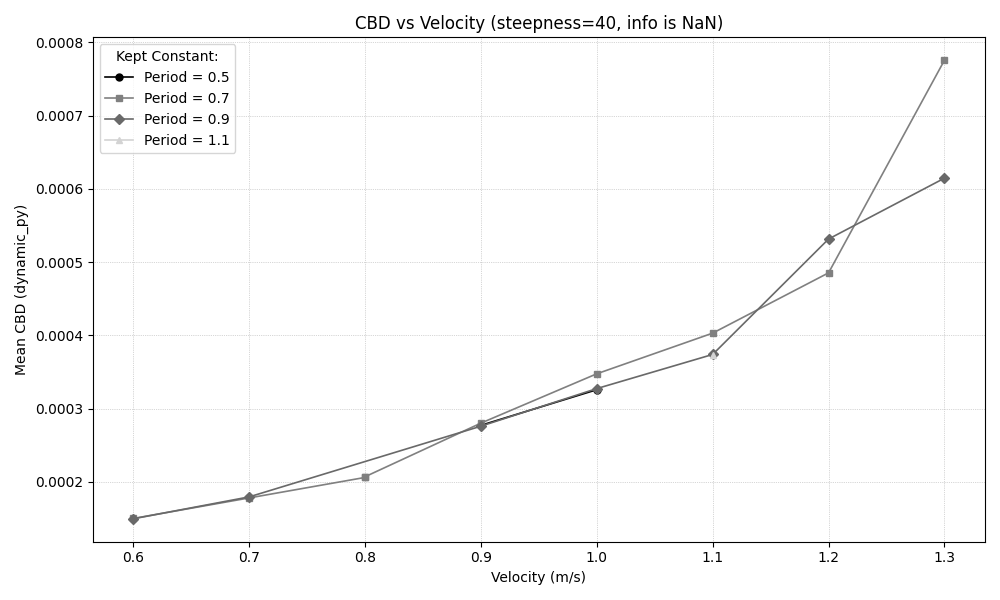

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Base-filter: steepness = 40 and info is NaN
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# 2) Gather all unique periods (sorted)
all_periods = np.sort(df_base["period"].unique())
print("All unique periods:", all_periods)

# If there are fewer than 4 distinct periods, just use them all.
# Otherwise pick four roughly equally spaced indices.
if len(all_periods) <= 4:
    selected_periods = all_periods.tolist()
else:
    idxs = np.linspace(0, len(all_periods) - 1, 4, dtype=int)
    selected_periods = all_periods[idxs].tolist()

print("Selected periods (evenly spaced):", selected_periods)

# 3) Plot CBD vs Velocity for each selected period
plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray", "lightgray"]
markers = ["o", "s", "D", "^"]

for idx, P in enumerate(selected_periods):
    df_P = df_base[df_base["period"] == P].dropna(subset=["velocity", "mean_CBD_dynamic_py"])
    print(f"  Period = {P}, rows: {len(df_P)}")
    if df_P.empty:
        continue

    df_P = df_P.sort_values(by="velocity")
    plt.plot(
        df_P["velocity"],
        df_P["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Period = {P}"
    )

plt.xlabel("Velocity (m/s)")
plt.ylabel("Mean CBD (dynamic_py)")
plt.title("CBD vs Velocity (steepness=40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Rows after base filter: 193
Unique velocities found: [0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]


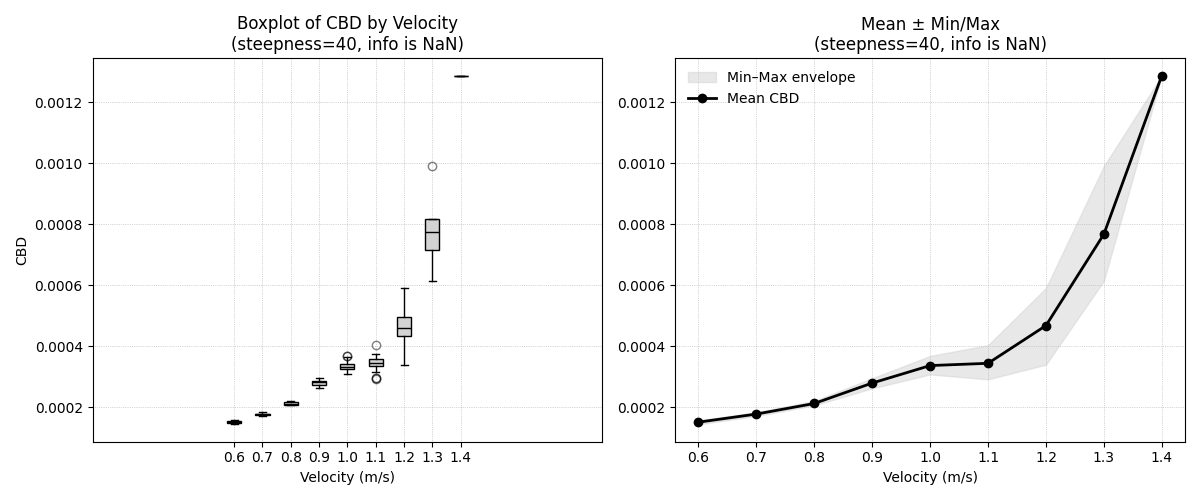

In [28]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Filter the main DataFrame for steepness=40 and info is NaN ---
# Assume `new_dataframe` already exists in your namespace.
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# --- 1) Prepare df_grouped with columns ['velocity', 'CBD'] ---
df_grouped = df_base.rename(columns={"mean_CBD_dynamic_py": "CBD"})[["velocity", "CBD"]]

# --- 2) Compute summary statistics by velocity ---
gb = df_grouped.groupby("velocity")["CBD"]
velocities = np.sort(gb.mean().index)
mean_vals = gb.mean().values
min_vals  = gb.min().values
max_vals  = gb.max().values
std_vals  = gb.std().values  # optional, if you want ±1σ later

print("Unique velocities found:", velocities)

# --- 3) Plotting: Panel A = boxplots, Panel B = mean ± min/max ---
plt.figure(figsize=(12, 5))

# Panel A: Boxplot of CBD at each velocity
plt.subplot(1, 2, 1)
data_for_boxes = [gb.get_group(v).values for v in velocities]
plt.boxplot(
    data_for_boxes,
    positions=velocities,
    widths=0.05,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", color="black", alpha=0.5),
)
plt.xlabel("Velocity (m/s)")
plt.ylabel("CBD")
plt.title("Boxplot of CBD by Velocity\n(steepness=40, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)

# Panel B: Mean ± Min/Max envelope
plt.subplot(1, 2, 2)
plt.fill_between(
    velocities,
    min_vals,
    max_vals,
    color="lightgray",
    alpha=0.5,
    label="Min–Max envelope",
)
plt.plot(
    velocities,
    mean_vals,
    color="black",
    linewidth=2,
    marker="o",
    label="Mean CBD",
)
plt.xlabel("Velocity (m/s)")
plt.title("Mean ± Min/Max\n(steepness=40, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


Rows after base filter: 193
  Velocity = 0.6, rows: 23


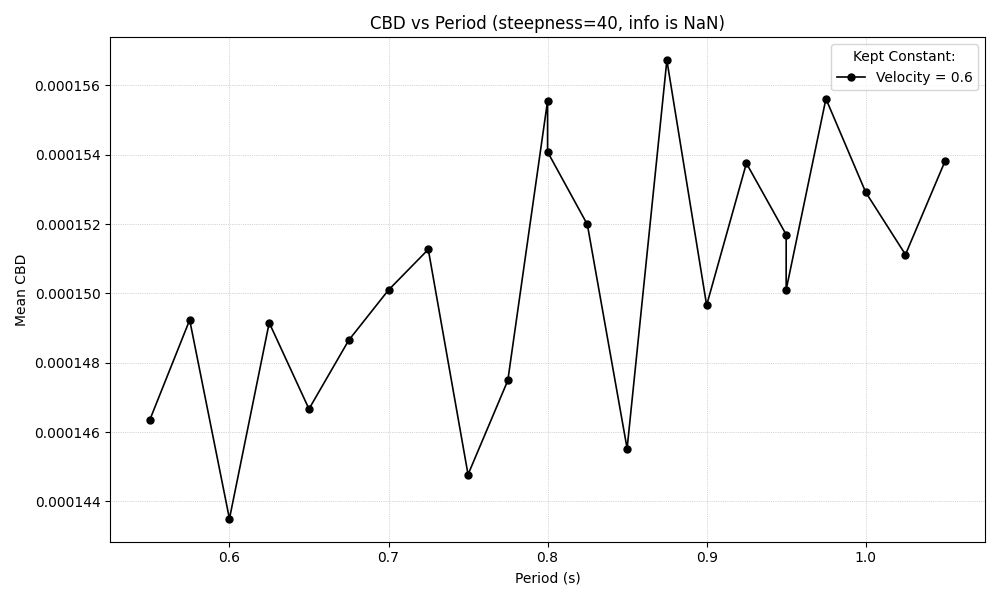

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Filter the main DataFrame for steepness=40 and info is NaN ---
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py", "min_CBD_dynamic_py", "max_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# --- 1) Specify velocities to plot (CBD vs. period for each) ---
velocities_to_plot = [0.6]  # adjust as needed

plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray"]
markers = ["o", "s", "D"]

for idx, V in enumerate(velocities_to_plot):
    df_V = df_base[df_base["velocity"] == V].dropna(subset=["period", "mean_CBD_dynamic_py"])
    print(f"  Velocity = {V}, rows: {len(df_V)}")
    if df_V.empty:
        continue

    df_V = df_V.sort_values(by="period")
    plt.plot(
        df_V["period"],
        df_V["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Velocity = {V}"
    )

plt.xlabel("Period (s)")
plt.ylabel("Mean CBD")
plt.title("CBD vs Period (steepness=40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


Rows after base filter: 193
  Velocity = 0.9, rows: 32


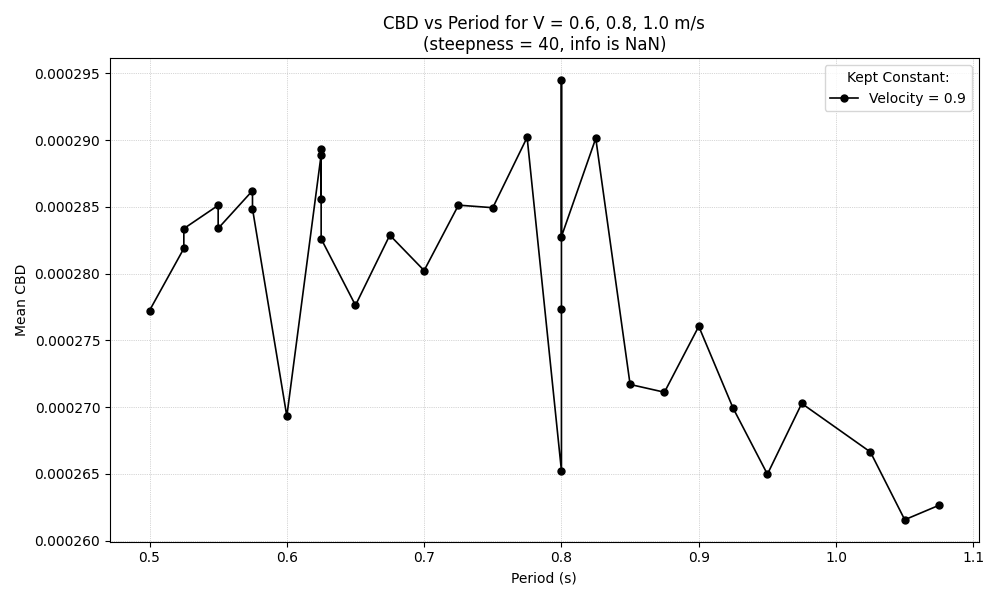

In [30]:

import numpy as np
import matplotlib.pyplot as plt

# --- 0) Filter the main DataFrame for steepness=40 and info is NaN ---
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py", "min_CBD_dynamic_py", "max_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# --- 1) Specify velocities to plot (CBD vs. period for each) ---
velocities_to_plot = [0.9]  # adjust as needed

plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray"]
markers = ["o", "s", "D"]

for idx, V in enumerate(velocities_to_plot):
    df_V = df_base[df_base["velocity"] == V].dropna(subset=["period", "mean_CBD_dynamic_py"])
    print(f"  Velocity = {V}, rows: {len(df_V)}")
    if df_V.empty:
        continue

    df_V = df_V.sort_values(by="period")
    plt.plot(
        df_V["period"],
        df_V["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Velocity = {V}"
    )

plt.xlabel("Period (s)")
plt.ylabel("Mean CBD")
plt.title("CBD vs Period for V = 0.6, 0.8, 1.0 m/s\n(steepness = 40, info is NaN)")
plt.legend(title="Kept Constant:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

Rows after base filter: 6
Unique velocities found: [0.6 0.7 1.  1.1 1.2 1.3]


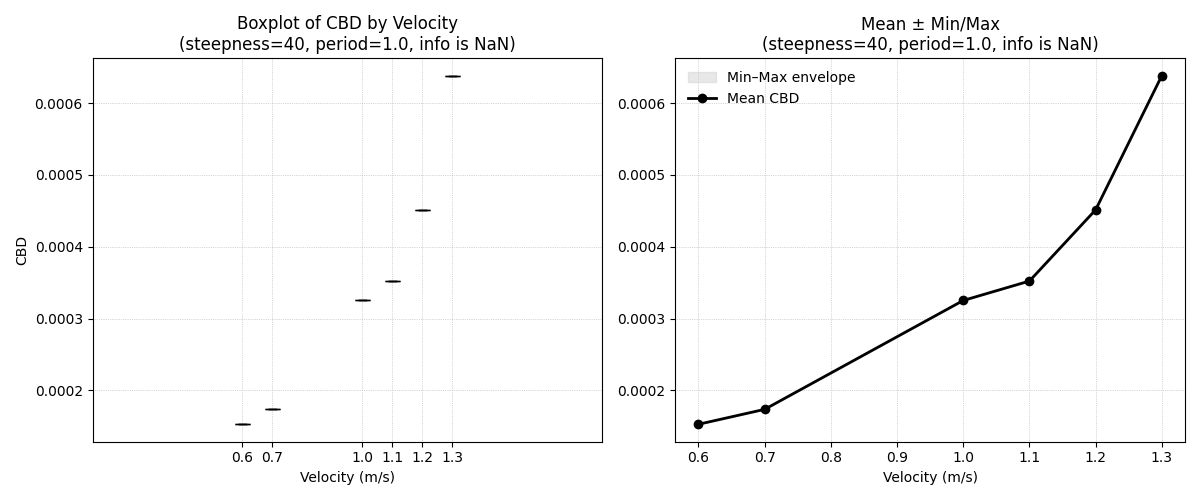

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Specify which period to hold constant (or vary over) ---
# For “CBD vs Velocity” we hold period fixed. Change P_fixed to one of your tested periods.
P_fixed = 1.0  # e.g. 1.0 s, adjust to a value that exists in new_dataframe['period']

# --- 1) Filter the DataFrame for steepness=40, info is NaN, and period=P_fixed ---
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna()) &
    (np.isclose(new_dataframe["period"], P_fixed, atol=1e-6))
].dropna(subset=["velocity", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))
if df_base.empty:
    raise ValueError(f"No rows match steepness=40, info is NaN, and period={P_fixed}.")

# --- 2) Prepare df_grouped with columns ['velocity', 'CBD'] ---
df_grouped = df_base.rename(columns={"mean_CBD_dynamic_py": "CBD"})[["velocity", "CBD"]]

# --- 3) Compute summary statistics by velocity ---
gb = df_grouped.groupby("velocity")["CBD"]
velocities = np.sort(gb.mean().index)
mean_vals = gb.mean().values
min_vals  = gb.min().values
max_vals  = gb.max().values
std_vals  = gb.std().values  # optional, if you want ±1σ

print("Unique velocities found:", velocities)

# --- 4) Plotting: Panel A = boxplots, Panel B = mean ± min/max ---
plt.figure(figsize=(12, 5))

# Panel A: Boxplot of CBD at each velocity
plt.subplot(1, 2, 1)
data_for_boxes = [gb.get_group(v).values for v in velocities]
plt.boxplot(
    data_for_boxes,
    positions=velocities,
    widths=0.05,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", color="black", alpha=0.5),
)
plt.xlabel("Velocity (m/s)")
plt.ylabel("CBD")
plt.title(f"Boxplot of CBD by Velocity\n(steepness=40, period={P_fixed}, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)

# Panel B: Mean ± Min/Max envelope
plt.subplot(1, 2, 2)
plt.fill_between(
    velocities,
    min_vals,
    max_vals,
    color="lightgray",
    alpha=0.5,
    label="Min–Max envelope",
)
plt.plot(
    velocities,
    mean_vals,
    color="black",
    linewidth=2,
    marker="o",
    label="Mean CBD",
)
plt.xlabel("Velocity (m/s)")
plt.title(f"Mean ± Min/Max\n(steepness=40, period={P_fixed}, info is NaN)")
plt.grid(linestyle=":", linewidth=0.5)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


Rows after base filter: 193
  Period = 0.6, rows: 8
  Period = 0.8, rows: 27
  Period = 1.0, rows: 6
  Period = 1.2, rows: 0


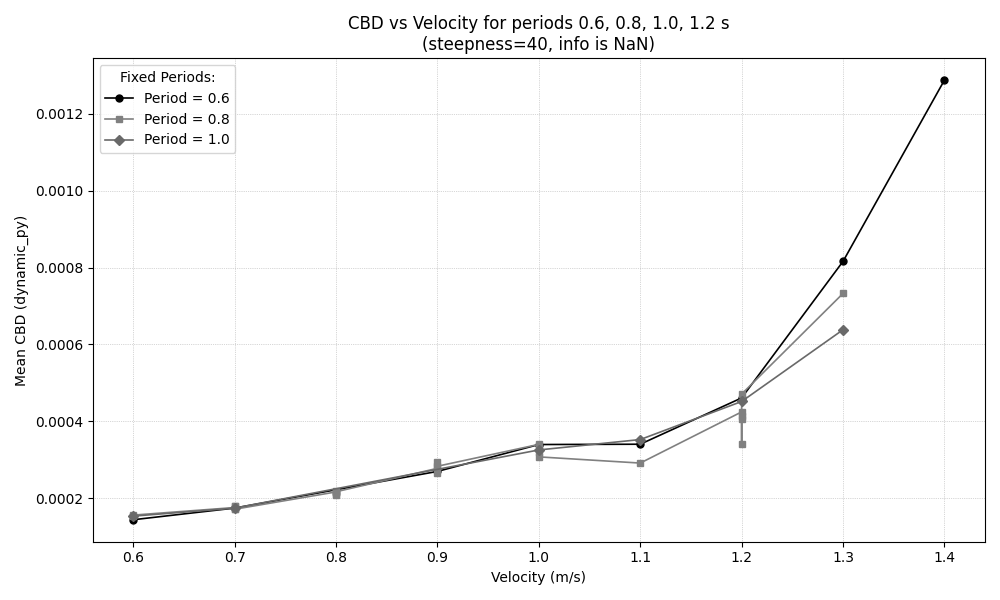

In [32]:

import numpy as np
import matplotlib.pyplot as plt

# 1) Base‐filter: steepness = 40 and info is NaN
df_base = new_dataframe[
    (new_dataframe["steepness"] == 40) &
    (new_dataframe["info"].isna())
].dropna(subset=["velocity", "period", "mean_CBD_dynamic_py"])

print("Rows after base filter:", len(df_base))

# 2) Specify the four periods to plot
periods_to_plot = [0.6, 0.8, 1.0, 1.2]

# 3) Plot CBD vs Velocity for each specified period
plt.figure(figsize=(10, 6))
colors = ["black", "gray", "dimgray", "lightgray"]
markers = ["o", "s", "D", "^"]

for idx, P in enumerate(periods_to_plot):
    df_P = df_base[np.isclose(df_base["period"], P, atol=1e-6)]
    df_P = df_P.dropna(subset=["velocity", "mean_CBD_dynamic_py"])
    print(f"  Period = {P}, rows: {len(df_P)}")
    if df_P.empty:
        continue

    df_P = df_P.sort_values(by="velocity")
    plt.plot(
        df_P["velocity"],
        df_P["mean_CBD_dynamic_py"],
        color=colors[idx],
        marker=markers[idx],
        linestyle="-",
        linewidth=1.2,
        markersize=5,
        label=f"Period = {P}"
    )

plt.xlabel("Velocity (m/s)")
plt.ylabel("Mean CBD (dynamic_py)")
plt.title("CBD vs Velocity for periods 0.6, 0.8, 1.0, 1.2 s\n(steepness=40, info is NaN)")
plt.legend(title="Fixed Periods:")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()



Rows after filtering: 193
Velocity = 0.60 m/s, points: 23
Velocity = 0.80 m/s, points: 23
Velocity = 1.00 m/s, points: 33


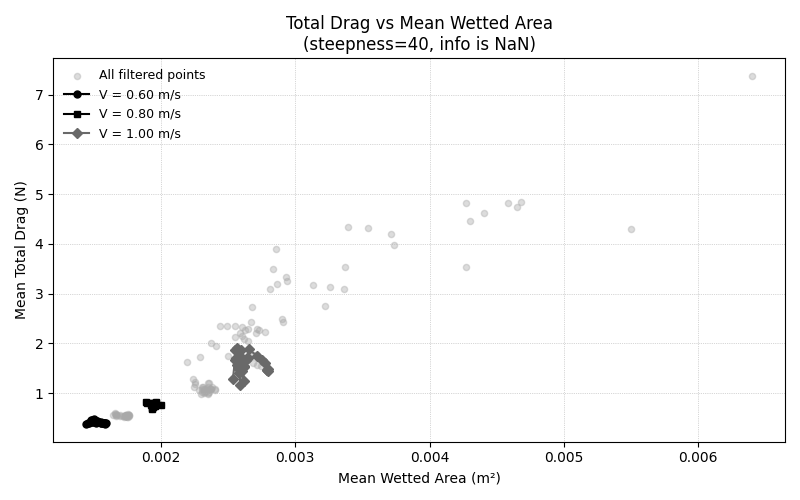

In [33]:

import numpy as np
import matplotlib.pyplot as plt

def plot_total_drag_vs_wetted_area(
    df,
    velocities_to_plot=None,
    steepness=40,
    info_missing=True
):
  
    # 1) Base filter on steepness and info if requested
    mask = (df["steepness"] == steepness)
    if info_missing:
        mask &= df["info"].isna()
    df_base = df[mask].dropna(subset=["velocity", "mean_wetted_area", "mean_second_half"])

    print("Rows after filtering:", len(df_base))
    if df_base.empty:
        raise ValueError(f"No rows match steepness={steepness}"
                         + (" and info is NaN." if info_missing else "."))

    # 2) Determine velocities to plot
    if velocities_to_plot is None:
        # pick up to 3 most common velocities
        counts = df_base["velocity"].value_counts().sort_index()
        velocities_to_plot = counts.index[:3].tolist()
        print("Auto-selected velocities:", velocities_to_plot)

    colors = ["black", "black", "dimgray", "darkgray"]
    markers = ["o", "s", "D", "^"]

    plt.figure(figsize=(8, 5))

    # 3) For context: scatter all points lightly in background
    plt.scatter(
        df_base["mean_wetted_area"],
        df_base["mean_second_half"],
        color="darkgray",
        alpha=0.4,
        s=20,
        label="All filtered points"
    )

    # 4) Plot one line per chosen velocity
    for idx, V in enumerate(velocities_to_plot):
        df_V = df_base[np.isclose(df_base["velocity"], V, atol=1e-6)]
        if df_V.empty:
            print(f"Velocity = {V} m/s: no data.")
            continue

        # Sort by wetted area
        df_V = df_V.sort_values(by="mean_wetted_area")
        x_vals = df_V["mean_wetted_area"].values
        y_vals = df_V["mean_second_half"].values

        print(f"Velocity = {V:.2f} m/s, points: {len(df_V)}")

        # Plot line connecting mean drag vs mean wetted area
        plt.plot(
            x_vals,
            y_vals,
            color=colors[idx % len(colors)],
            marker=markers[idx % len(markers)],
            linestyle="-",
            linewidth=1.5,
            markersize=5,
            label=f"V = {V:.2f} m/s"
        )

    plt.xlabel("Mean Wetted Area (m²)")
    plt.ylabel("Mean Total Drag (N)")
    title = "Total Drag vs Mean Wetted Area\n"
    title += f"(steepness={steepness}"
    title += ", info is NaN)" if info_missing else ")"
    plt.title(title)

    plt.grid(linestyle=":", linewidth=0.5)
    plt.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

# Example 1: explicitly specify three velocities
plot_total_drag_vs_wetted_area(
    new_dataframe,
    velocities_to_plot=[0.6, 0.8, 1.0],
    steepness=40
)




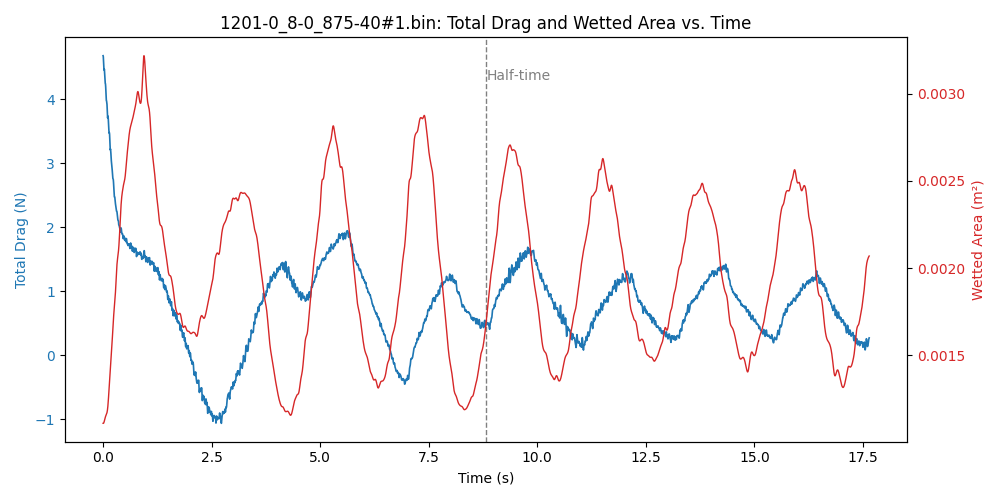

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def calc_wetted_area_timeseries(
    file_name,
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,             # sample interval (200 Hz)
    cutoff_hz=20.0,       # low‐pass cutoff for water height
    root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"
):
    """
    Returns a NumPy array with the filtered wetted‐area vs time for the entire speed-aligned record.

    Steps:
      1) Load the two water‐probe channels (speed‐aligned) via get_speedaligned_channel(...)
      2) Low‐pass filter both at cutoff_hz using a 3rd‐order Butterworth
      3) Compute the instantaneous wetted area from those two water heights at each time
      4) Low‐pass filter the wetted‐area time series (same cutoff_hz) and return it
    """
    # --- 1) Load raw, speed‐aligned water‐probe signals ---
    w1 = get_speedaligned_channel(file_name, wave_channels[0], root_folder=root_folder)
    w2 = get_speedaligned_channel(file_name, wave_channels[1], root_folder=root_folder)
    if w1 is None or w2 is None or len(w1)==0 or len(w2)==0:
        raise ValueError(f"Could not load water probes for {file_name}")

    # --- 2) Low‐pass filter each water height at cutoff_hz ---
    nyq = 0.5 / dt
    wn  = cutoff_hz / nyq
    b, a = butter(N=3, Wn=wn, btype="low")
    water1 = filtfilt(b, a, w1)
    water2 = filtfilt(b, a, w2)

    # --- 3) Compute instantaneous wetted‐area of transom at each time step ---
    # Use the same hull “lookup arrays” as before:
    widths = np.array([0, 0.04642, 0.0599, 0.0667, 0.07633, 0.08425, 0.09175, 0.09859, 0.10401, 0.09898, 0.093752])
    heights= np.array([0, 0.001177, 0.00392, 0.00865, 0.02201, 0.03408, 0.0466, 0.0591,   0.07415,  0.0882,  0.10254])

    # instantaneous water height (average of two probes) + small offset:
    water_height = (water1 + water2) / 2 + 0.01

    wetted_area = np.zeros_like(water_height)
    for i, h in enumerate(water_height):
        h_clip = np.clip(h, 0, heights[-1])
        # build the “transom cross‐section” up to height h_clip
        w_accum = []
        h_accum = []
        for j in range(len(heights) - 1):
            if heights[j+1] >= h_clip:
                # linear interp between (heights[j], widths[j]) and (heights[j+1], widths[j+1])
                w_int = widths[j] + (widths[j+1] - widths[j]) * (h_clip - heights[j]) / (heights[j+1] - heights[j])
                w_accum += [widths[j], w_int]
                h_accum += [heights[j], h_clip]
                break
            w_accum += [widths[j]]
            h_accum += [heights[j]]
        # close at zero:
        w_accum = [0] + w_accum
        h_accum = [0] + h_accum
        # trapezoidal rule to find half‐area, then multiply by 2
        area = 2 * np.trapezoid(w_accum, h_accum)
        wetted_area[i] = area

    # --- 4) Low‐pass filter the wetted‐area time series itself ---
    b2, a2 = butter(N=3, Wn=wn, btype="low")
    wetted_area_filt = filtfilt(b2, a2, wetted_area)

    return wetted_area_filt


def plot_drag_and_wetted_area(
    file_name,
    drag_channel_name="Total_Drag",           # replace with your actual drag channel
    wave_channels=("Rel_WP1", "Rel_WP2"),      # your water‐probe channels
    dt=1/200,
    cutoff_hz=20.0,
    root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"
):
    """
    For a single test (file_name), plot:
      - Total Drag vs Time (first half + second half)
      - Wetted Area vs Time (filtered)
    on a shared time axis, using twin y‐axes.
    """
    # --- A) Load total drag time series (speed‐aligned) ---
    drag_ts = get_speedaligned_channel(file_name, drag_channel_name, root_folder=root_folder)
    if drag_ts is None or len(drag_ts)==0:
        raise ValueError(f"Could not load drag channel '{drag_channel_name}' for {file_name}")

    # Assume the returned array is sampled at dt, so time vector is:
    N = len(drag_ts)
    t = np.linspace(0, dt*(N-1), N)

    # --- B) Compute wetted‐area time series ---
    wetted_area_ts = calc_wetted_area_timeseries(
        file_name,
        wave_channels=wave_channels,
        dt=dt,
        cutoff_hz=cutoff_hz,
        root_folder=root_folder
    )

    # Check lengths match (they should, since both are speed‐aligned and same dt)
    if len(wetted_area_ts) != N:
        raise ValueError("Wetted area and drag have different lengths!")

    # --- C) Plot both on shared x (time) with twin y‐axes ---
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color1 = "tab:blue"
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Total Drag (N)", color=color1)
    ax1.plot(t, drag_ts, color=color1, linewidth=1.2, label="Total Drag")
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel("Wetted Area (m²)", color=color2)
    ax2.plot(t, wetted_area_ts, color=color2, linewidth=1.0, label="Wetted Area")
    ax2.tick_params(axis="y", labelcolor=color2)

    # Optionally, mark the “second half” boundary
    mid_idx = N // 2
    ax1.axvline(t[mid_idx], color="gray", linestyle="--", linewidth=1)
    ax1.text(t[mid_idx], ax1.get_ylim()[1]*0.9, "Half‐time", color="gray", ha="left", va="top")

    plt.title(f"{file_name}: Total Drag and Wetted Area vs. Time")
    fig.tight_layout()
    plt.show()


# ===== Example Usage =====
# Replace "test1.bin" or whatever your filename is:
plot_drag_and_wetted_area(
    file_name="1201-0_8-0_875-40#1.bin",
    drag_channel_name="FX_total",    # <-- change if your drag channel has a different name
    wave_channels=("Rel_WP1", "Rel_WP2"),
    dt=1/200,
    cutoff_hz=20.0,
    root_folder=r"\\sambaad.stud.ntnu.no\arthursl\.profil\stud\datasal\Desktop\Master\Master\Code\PostProcess\Resultater"
)


# TRIM PÅVIRKNING


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_cbd_heatmap(df):
    """
    Plots a heatmap of mean_CBD_dynamic_py * 1000 with velocity on the x-axis and period on the y-axis.
    Filters for steepness = 40 and info is NaN.
    """
    if df is None or df.empty:
        print("Input DataFrame is empty or None.")
        return

    # Filter data
    df_filtered = df[
        (df["steepness"] == 40) &
        (df["info"].isna())
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Scale CBD values
    df_filtered["mean_CBD_dynamic_py_scaled"] = df_filtered["mean_CBD_dynamic_py"] * 1000

    # Drop NaNs essential for pivot and plotting
    df_filtered.dropna(subset=["period", "velocity", "mean_CBD_dynamic_py_scaled"], inplace=True)

    if df_filtered.empty:
        print("No data available after filtering for steepness=40, info=NaN, scaling CBD, and removing NaNs in key columns.")
        return

    # Create pivot table with Period on Y-axis and Velocity on X-axis
    try:
        pivot_df = df_filtered.pivot_table(
            index='period',      # Period on Y-axis
            columns='velocity',  # Velocity on X-axis
            values='mean_CBD_dynamic_py_scaled',
            aggfunc='mean' 
        )
    except Exception as e:
        print(f"Could not create pivot table: {e}")
        return

    if pivot_df.empty:
        print("Pivot table is empty. Cannot generate heatmap.")
        return

    # Sort index (period) and columns (velocity) for a more organized plot
    pivot_df.sort_index(axis=0, inplace=True) # Sort periods
    pivot_df.sort_index(axis=1, inplace=True) # Sort velocities

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5, cbar_kws={'label': 'Mean CBD * 10^3'})
    
    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Period (s)")
    plt.title("Heatmap of Mean CBD * 10^3 (dynamic_py)\n(Steepness=40, Info is NaN)")
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'new_dataframe' is loaded and available
# plot_cbd_heatmap(new_dataframe)

ModuleNotFoundError: No module named 'seaborn'

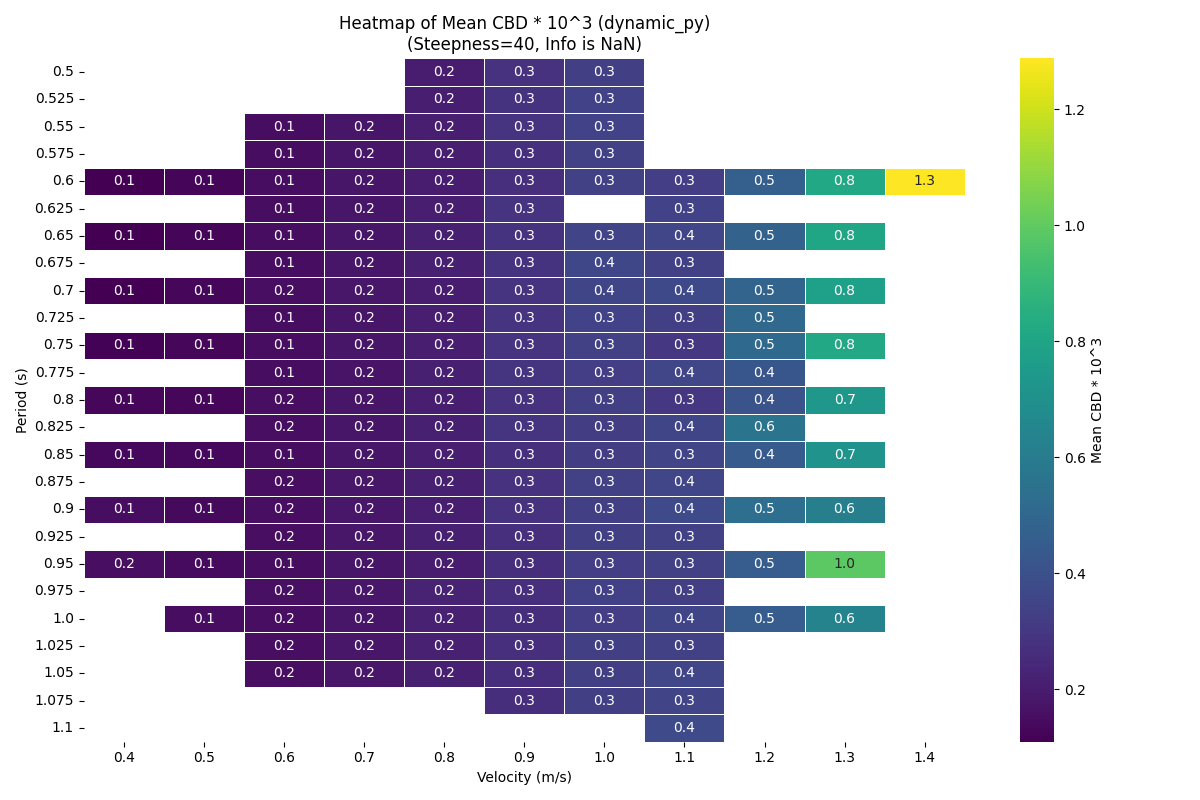

In [ ]:
# Call the new function
# Make sure 'new_dataframe' is loaded in your notebook environment before running this cell.
# If new_dataframe is not loaded, you might need to re-run the cell that creates it,
# or load it from a CSV if you saved it previously.

# Example: if new_dataframe is not defined, you might load it like this:
# try:
#     new_dataframe
# except NameError:
#     print("new_dataframe not found, attempting to load from my_data.csv")
#     try:
#         new_dataframe = pd.read_csv("my_data.csv")
#     except FileNotFoundError:
#         print("my_data.csv not found. Please ensure new_dataframe is created or loaded.")
#         new_dataframe = pd.DataFrame() # Create an empty df to avoid further errors if user runs this cell directly

if 'new_dataframe' in locals() and not new_dataframe.empty:
    plot_cbd_heatmap(new_dataframe)
else:
    print("DataFrame 'new_dataframe' is not available or is empty. Cannot plot heatmap.")
    print("Please ensure 'new_dataframe' is created by running the 'make_dataframe_all_new()' cell or loaded from a file.")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_max_cbd_heatmap(df):
    """
    Plots a heatmap of max_CBD_dynamic_py * 1000 with velocity on the x-axis and period on the y-axis.
    Filters for steepness = 40 and info is NaN.
    """
    if df is None or df.empty:
        print("Input DataFrame is empty or None.")
        return

    # Filter data
    df_filtered = df[
        (df["steepness"] == 40) &
        (df["info"].isna())
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Scale Max CBD values
    df_filtered["max_CBD_dynamic_py_scaled"] = df_filtered["max_CBD_dynamic_py"] * 1000

    # Drop NaNs essential for pivot and plotting
    df_filtered.dropna(subset=["period", "velocity", "max_CBD_dynamic_py_scaled"], inplace=True)

    if df_filtered.empty:
        print("No data available after filtering for steepness=40, info=NaN, scaling Max CBD, and removing NaNs in key columns.")
        return

    # Create pivot table with Period on Y-axis and Velocity on X-axis
    try:
        pivot_df = df_filtered.pivot_table(
            index='period',      # Period on Y-axis
            columns='velocity',  # Velocity on X-axis
            values='max_CBD_dynamic_py_scaled',
            aggfunc='mean'  # If multiple tests have same period/velocity, take the mean of their max values.
                           # Or consider 'max' if you want the absolute max across repeats.
        )
    except Exception as e:
        print(f"Could not create pivot table: {e}")
        return

    if pivot_df.empty:
        print("Pivot table is empty. Cannot generate heatmap.")
        return

    # Sort index (period) and columns (velocity) for a more organized plot
    pivot_df.sort_index(axis=0, inplace=True) # Sort periods
    pivot_df.sort_index(axis=1, inplace=True) # Sort velocities

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="viridis", linewidths=.5, cbar_kws={'label': 'Max CBD * 10^3'})
    
    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Period (s)")
    plt.title("Heatmap of Max CBD * 10^3 (dynamic_py)\n(Steepness=40, Info is NaN)")
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'new_dataframe' is loaded and available
# plot_max_cbd_heatmap(new_dataframe)

In [ ]:
# Call the new function for Max CBD heatmap
if 'new_dataframe' in locals() and not new_dataframe.empty:
    plot_max_cbd_heatmap(new_dataframe)
else:
    print("DataFrame 'new_dataframe' is not available or is empty. Cannot plot Max CBD heatmap.")
    print("Please ensure 'new_dataframe' is created by running the 'make_dataframe_all_new()' cell or loaded from a file.")
